Leemos `data.csv` (generado previamente) y filtra solo las filas cuya columna `maneuver` está en {Stopping, Overtaking, Turnings}.

In [3]:
import pandas as pd

# Lee el CSV creado
df = pd.read_csv("data_filtered.csv")
df = df[['driver', 'maneuver', 'Elapsed time', 'speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear', 'Maneuver marker flag']]
df[['Gear', 'Maneuver marker flag']] = df[['Gear', 'Maneuver marker flag']].astype('category')
df.shape

(136544, 11)

In [4]:
# Filtra por maniobras de interés
allowed = {"Stopping", "Overtaking", "Turnings"}
df_filtered = df[df["maneuver"].isin(allowed)].copy()
df_filtered.shape

(136544, 11)

In [5]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136544 entries, 0 to 136543
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   driver                136544 non-null  object  
 1   maneuver              136544 non-null  object  
 2   Elapsed time          136544 non-null  float64 
 3   speed                 136544 non-null  float64 
 4   RPM                   136544 non-null  float64 
 5   Steering wheel angle  136544 non-null  float64 
 6   Gas pedal             136544 non-null  int64   
 7   Brake pedal           136544 non-null  int64   
 8   Clutch pedal          136544 non-null  int64   
 9   Gear                  136544 non-null  category
 10  Maneuver marker flag  136544 non-null  category
dtypes: category(2), float64(4), int64(3), object(2)
memory usage: 9.6+ MB


In [6]:
# Vista previa
df_filtered.head()

,driver,maneuver,Elapsed time,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
0,Driver1,Overtaking,0.111,0.08,124.216,-6.18,0,0,10601,0,0
1,Driver1,Overtaking,0.161,0.05,162.215,-6.18,0,0,10601,0,0
2,Driver1,Overtaking,0.213,0.03,198.359,-6.18,0,0,10601,0,0
3,Driver1,Overtaking,0.265,0.01,232.738,-6.18,0,0,10601,0,0
4,Driver1,Overtaking,0.316,0.00,265.438,-6.18,0,0,10601,0,0


In [7]:
# cell 4
import numpy as np

# Asegura tipo numérico (por si hubiera strings raros)
df_filtered["Elapsed time"] = pd.to_numeric(df_filtered["Elapsed time"], errors="coerce")

# Ordena por driver, maneuver y elapsed time DESC (para evaluar y también para análisis posterior)
df_sorted = df_filtered.sort_values(["driver", "maneuver", "Elapsed time"],
                                    ascending=[True, True, False]).copy()

# --- 1) Comprobar si cada grupo ya venía ordenado en ASC ---
# Creamos una versión "como venía" (orden original del CSV) para evaluar si estaba ya bien
df_orig = df_filtered.copy()
df_orig["_row_id"] = np.arange(len(df_orig))  # conserva el orden original dentro del filtrado

def is_asc_sorted(g):
    # verifica si Elapsed time es no decreciente (creciente permitiendo iguales)
    t = g["Elapsed time"].to_numpy()
    return np.all(np.diff(t) >= 0)

order_check = (
    df_orig.sort_values(["driver", "maneuver", "_row_id"])
.groupby(["driver", "maneuver"], sort=False)
.apply(is_asc_sorted)
.rename("is_asc_sorted")
.reset_index()
)

print("Grupos NO ordenados en Elapsed time ascendente (según orden original):")
not_sorted = order_check[~order_check["is_asc_sorted"]]
display(not_sorted if len(not_sorted) else order_check.head(0))

# --- 2) Comprobar Δt entre filas consecutivas dentro de cada grupo (en el df ya ordenado DESC) ---
# Δt = elapsed(t_i) - elapsed(t_{i+1}) debería estar en [0.04, 0.06]
df_sorted["dt"] = df_sorted.groupby(["driver", "maneuver"])["Elapsed time"].diff(-1)

# tolerancia por floats
lo, hi = 0.04, 0.06
eps = 1e-6

# Ignora la última fila de cada grupo (dt = NaN)
bad_dt_mask = df_sorted["dt"].notna() & ~df_sorted["dt"].between(lo - eps, hi + eps)

bad_dt = df_sorted.loc[bad_dt_mask, ["driver", "maneuver", "Elapsed time", "dt"]]

print(f"Número de diferencias Δt fuera de [{lo}, {hi}]: {len(bad_dt)}")
display(bad_dt.head(20))


Grupos NO ordenados en Elapsed time ascendente (según orden original):


,driver,maneuver,is_asc_sorted


Número de diferencias Δt fuera de [0.04, 0.06]: 6


,driver,maneuver,Elapsed time,dt
61055,Driver3,Stopping,360.618,0.097
61041,Driver3,Stopping,359.859,0.115
60307,Driver3,Stopping,322.179,0.147
60216,Driver3,Stopping,317.419,0.173
60197,Driver3,Stopping,316.312,0.062
70320,Driver3,Turnings,190.990,0.157


In [10]:
# Relleno de huecos (dt > 0.06) con timestamps intermedios + interpolacion
dt_min, dt_max = 0.04, 0.06
step_target = 0.05
eps = 1e-9
window_seconds = 0.15  # ventana para categoricas alrededor del timestamp nuevo

num_cols = df_filtered.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in df_filtered.columns if c not in num_cols]
cat_cols = [c for c in cat_cols if c not in ["driver", "maneuver"]]

def _make_splits(t0, t1):
    gap = t1 - t0
    if gap <= dt_max + eps:
        return []
    n = max(1, int(round(gap / step_target)))
    # Ajusta n para que el paso quede dentro de [dt_min, dt_max] si es posible
    while n > 1 and gap / n < dt_min - eps:
        n -= 1
    while gap / n > dt_max + eps:
        n += 1
    step = gap / n
    if step < dt_min - eps or step > dt_max + eps:
        return None  # no se puede cumplir el rango exactamente
    return [t0 + step * k for k in range(1, n)]

filled_groups = []
unfixable_gaps = []

for (drv, man), g in df_filtered.groupby(["driver", "maneuver"], sort=False):
    g = g.sort_values("Elapsed time")
    rows = []
    prev_time = None
    for _, row in g.iterrows():
        if prev_time is not None:
            split_times = _make_splits(prev_time, row["Elapsed time"])
            if split_times is None:
                unfixable_gaps.append((drv, man, prev_time, row["Elapsed time"]))
            elif split_times:
                for t in split_times:
                    new_row = {c: np.nan for c in g.columns}
                    new_row["driver"] = drv
                    new_row["maneuver"] = man
                    new_row["Elapsed time"] = t
                    new_row["_is_new"] = True
                    rows.append(new_row)
        orig_row = row.to_dict()
        orig_row["_is_new"] = False
        rows.append(orig_row)
        prev_time = row["Elapsed time"]
    g_filled = pd.DataFrame(rows)
    filled_groups.append(g_filled)

df_filled = pd.concat(filled_groups, ignore_index=True)
df_filled = df_filled.sort_values(["driver", "maneuver", "Elapsed time"]).reset_index(drop=True)

# Interpola columnas numericas por grupo usando el tiempo como indice
def _interp_numeric(group):
    drv, man = group.name
    group = group.sort_values("Elapsed time")
    idx = group["Elapsed time"]
    num_data = group[num_cols].set_index(idx)
    num_filled = num_data.interpolate(method="linear", limit_direction="both")
    group[num_cols] = num_filled.to_numpy()
    # Reinsertar claves de agrupacion (excluidas por include_groups=False)
    group["driver"] = drv
    group["maneuver"] = man
    return group

df_filled = df_filled.groupby(["driver", "maneuver"], group_keys=False).apply(_interp_numeric)

# Interpola categoricas por modo en ventana temporal alrededor del timestamp nuevo
def _fill_categoricals(group):
    drv, man = group.name
    group = group.sort_values("Elapsed time").reset_index(drop=True)
    orig = group[~group["_is_new"]]
    for i, row in group[group["_is_new"]].iterrows():
        t = row["Elapsed time"]
        win = orig[(orig["Elapsed time"] >= t - window_seconds) & (orig["Elapsed time"] <= t + window_seconds)]
        if win.empty:
            # fallback: usa la fila original mas cercana
            idx = (orig["Elapsed time"] - t).abs().idxmin()
            win = orig.loc[[idx]]
        for c in cat_cols:
            if pd.isna(group.at[i, c]):
                mode_vals = win[c].dropna().mode()
                if len(mode_vals):
                    group.at[i, c] = mode_vals.iloc[0]
    # Reinsertar claves de agrupacion (excluidas por include_groups=False)
    group["driver"] = drv
    group["maneuver"] = man
    return group

df_filled = df_filled.groupby(["driver", "maneuver"], group_keys=False).apply(_fill_categoricals)

# Validacion de dt en el resultado
df_filled["dt"] = df_filled.groupby(["driver", "maneuver"])["Elapsed time"].diff()
bad_dt_after = df_filled["dt"].notna() & ~df_filled["dt"].between(dt_min - 1e-6, dt_max + 1e-6)

print(f"Huecos no resolubles con el rango exacto: {len(unfixable_gaps)}")
print(f"Numero de dt fuera de rango despues del relleno: {bad_dt_after.sum()}")
display(df_filled.loc[bad_dt_after, ["driver", "maneuver", "Elapsed time", "dt"]].head(20))


Huecos no resolubles con el rango exacto: 1
Numero de dt fuera de rango despues del relleno: 1


,driver,maneuver,Elapsed time,dt
6118,Driver3,Stopping,316.312,0.062


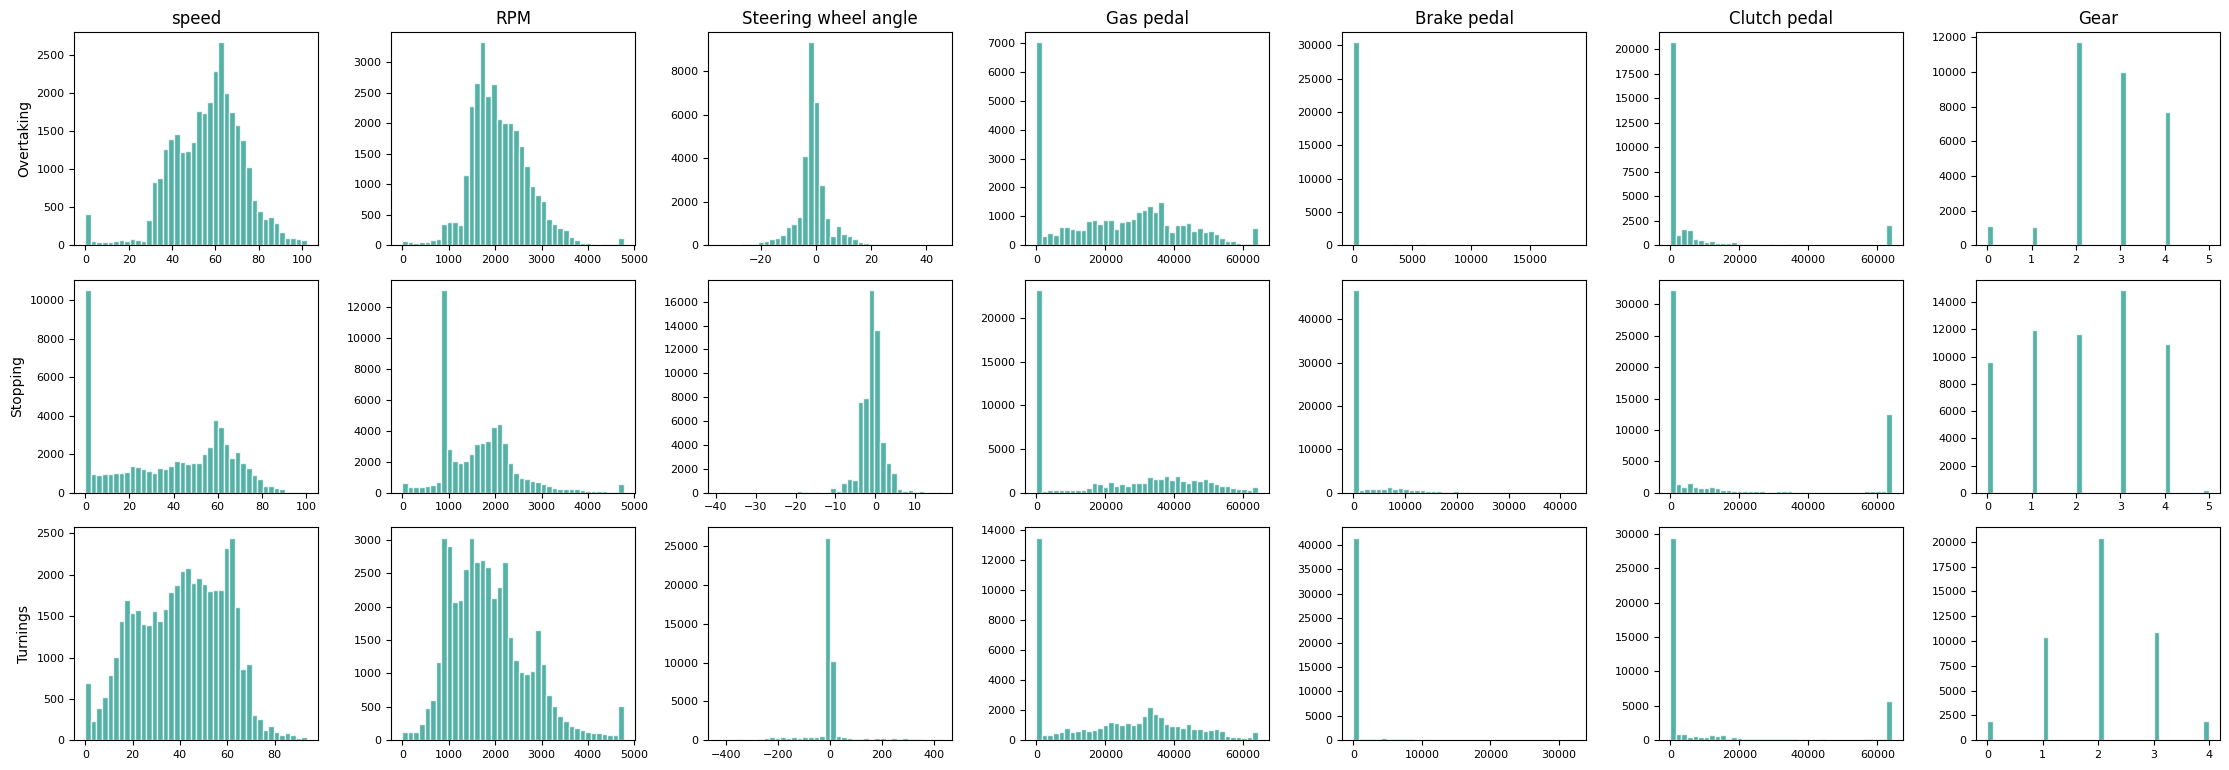

In [15]:
# Histogramas en matriz por maniobra y magnitud
import matplotlib.pyplot as plt

vars_to_plot = ["speed", "RPM", "Steering wheel angle", "Gas pedal", "Brake pedal", "Clutch pedal", "Gear"]
maneuvers = sorted(df_filtered["maneuver"].dropna().unique())

missing_vars = [v for v in vars_to_plot if v not in df_filtered.columns]
if missing_vars:
    print("Columnas no encontradas:", missing_vars)

plot_vars = [v for v in vars_to_plot if v in df_filtered.columns]
nrows = len(maneuvers)
ncols = len(plot_vars)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.2 * ncols, 2.6 * nrows), sharex=False, sharey=False)
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

for i, man in enumerate(maneuvers):
    data_m = df_filtered[df_filtered["maneuver"] == man]
    for j, var in enumerate(plot_vars):
        ax = axes[i][j]
        vals = data_m[var].dropna()
        ax.hist(vals, bins=40, color="#2a9d8f", alpha=0.8, edgecolor="white")
        if i == 0:
            ax.set_title(var)
        if j == 0:
            ax.set_ylabel(man)
        ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()
plt.show()

/tmp/ipykernel_369417/2769436221.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m["time_bin"] = data_m["pct_time"].round()
/tmp/ipykernel_369417/2769436221.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m["time_bin"] = data_m["pct_time"].round()
/tmp/ipykernel_369417/2769436221.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

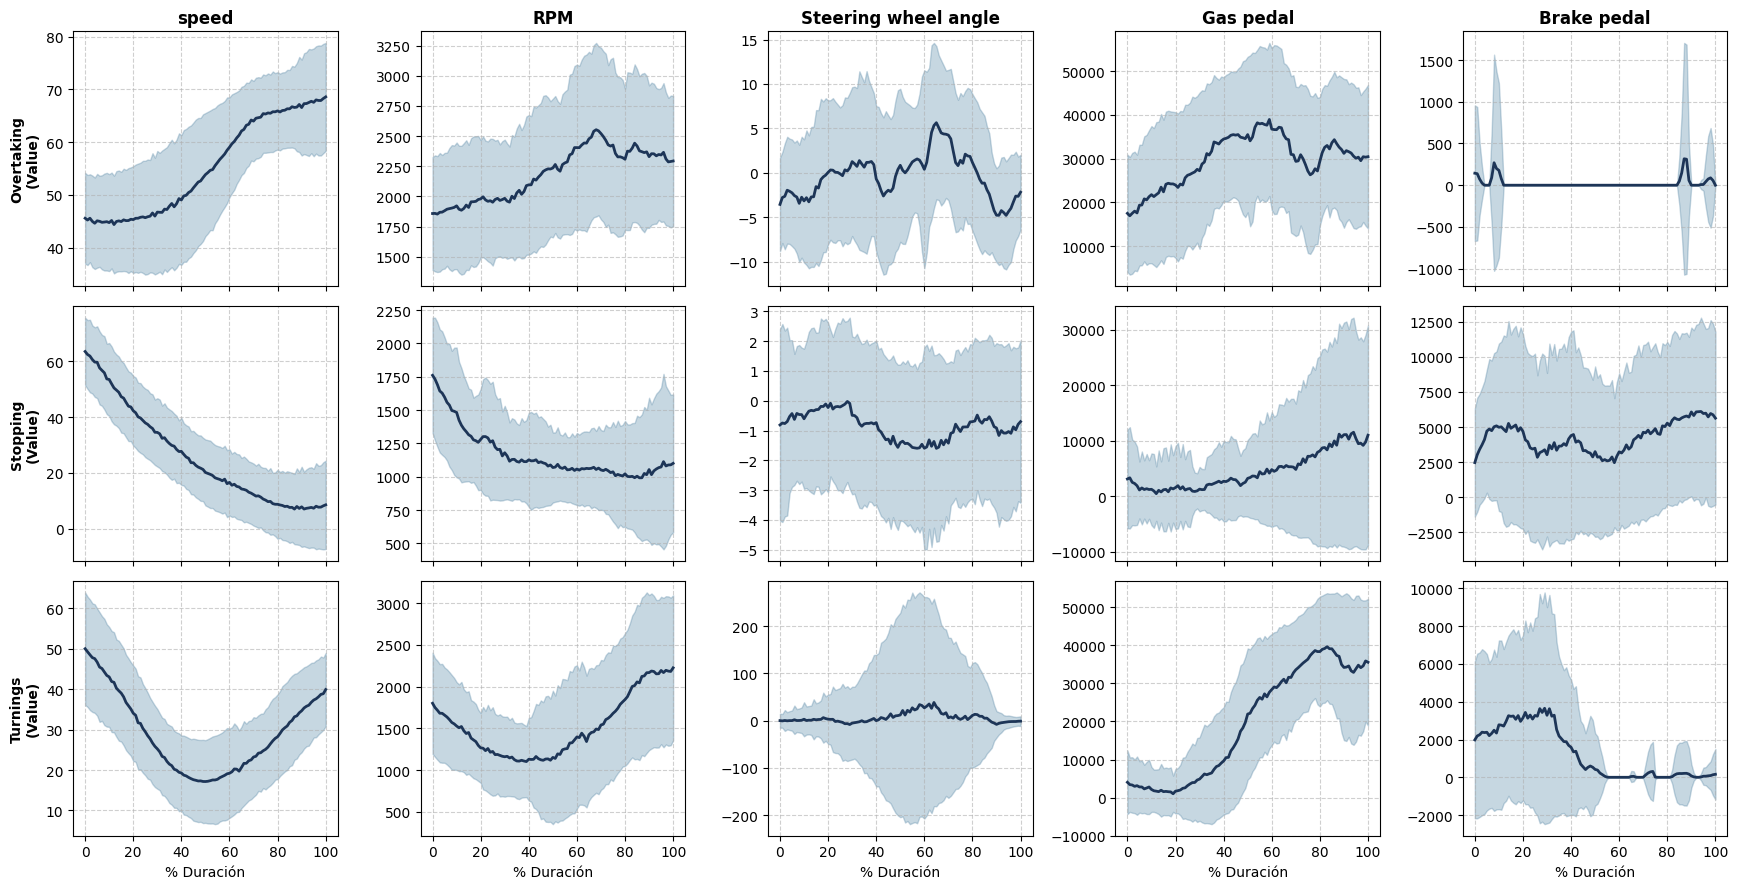

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Definir variables y maniobras
vars_to_plot = ["speed", "RPM", "Steering wheel angle", "Gas pedal", "Brake pedal"]
maneuvers = sorted(df_filtered["maneuver"].dropna().unique())
plot_vars = [v for v in vars_to_plot if v in df_filtered.columns]

# 2. Filtrar solo cuando la maniobra está activa y crear ID de instancia
# Usamos un truco: cada vez que el flag cambia de 0 a 1, es una nueva ejecución
df_active = df_filtered[df_filtered["Maneuver marker flag"] == 1].copy()
# Identifica bloques contiguos de maniobra para no mezclar ejecuciones distintas
df_active['instance_id'] = (df_active.groupby(['driver', 'maneuver'])['Elapsed time']
                            .diff() > 1.0).cumsum()

def normalize_time(group):
    t = group["Elapsed time"]
    group["pct_time"] = ((t - t.min()) / (t.max() - t.min())) * 100
    return group

# Aplicar normalización por cada ejecución individual
df_norm = df_active.groupby(['driver', 'maneuver', 'instance_id'], group_keys=False).apply(normalize_time)

# 3. Configurar la matriz de gráficos
nrows = len(maneuvers)
ncols = len(plot_vars)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5 * ncols, 3 * nrows), sharex=True)

# Asegurar que axes sea siempre una matriz 2D
if nrows == 1: axes = [axes]
if ncols == 1: axes = [[ax] for ax in axes]

# 4. Generar los gráficos
for i, man in enumerate(maneuvers):
    data_m = df_norm[df_norm["maneuver"] == man]
    
    # Agrupamos por porcentaje de tiempo (redondeado para tener puntos discretos)
    data_m["time_bin"] = data_m["pct_time"].round()
    
    # Calculamos media y desviación estándar
    summary = data_m.groupby("time_bin")[plot_vars].agg(["mean", "std"])
    
    for j, var in enumerate(plot_vars):
        ax = axes[i][j]
        
        # Datos para el eje X (0-100%) y eje Y (media)
        x = summary.index
        mean_val = summary[(var, "mean")]
        std_val = summary[(var, "std")]
        
        # Dibujar línea de la media
        ax.plot(x, mean_val, color="#1d3557", lw=2, label="Media")
        
        # Dibujar sombra de la desviación estándar (variabilidad entre conductores/ejecuciones)
        ax.fill_between(x, mean_val - std_val, mean_val + std_val, color="#457b9d", alpha=0.3)
        
        # Formateo
        if i == 0:
            ax.set_title(var, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{man}\n(Value)", fontweight='bold')
        if i == nrows - 1:
            ax.set_xlabel("% Duración")
            
        ax.grid(True, linestyle='--', alpha=0.6)



plt.tight_layout()
plt.savefig("perfiles_temporales_maniobras.png", dpi=300)
plt.show()

In [16]:
# Comprueba si hay Gear == -1 en maniobra Stopping
mask_gear_neg = (df_filtered["Gear"].astype("Int64") == -1)
count = mask_gear_neg.sum()
print(f"Filas con Gear == -1: {count}")
if count:
    display(df_filtered.loc[mask_gear_neg, ["driver", "maneuver", "Elapsed time", "Gear"]].head(20))

Filas con Gear == -1: 0


In [17]:
# Elimina filas con Gear == -1 (cualquier maniobra)
df_filtered = df_filtered.loc[~mask_gear_neg].copy()
df_filtered.shape

(136476, 11)

In [18]:
# Escalado robusto (winsor + minmax) a [0,1]
scale_cols = ["Gas pedal", "Brake pedal", "Clutch pedal", "speed", "RPM"]
steer_col = "Steering wheel angle"

p_low, p_high = 0.1, 0.9  # percentiles para winsorizar
df_scaled = df_filtered.copy()

def robust_minmax(series, p_lo, p_hi):
    lo = series.quantile(p_lo)
    hi = series.quantile(p_hi)
    clipped = series.clip(lower=lo, upper=hi)
    denom = (hi - lo) if hi != lo else 1.0
    return (clipped - lo) / denom

# Escala columnas positivas a [0,1]
for col in scale_cols:
    if col in df_scaled.columns:
        df_scaled[col] = robust_minmax(df_scaled[col].astype(float), p_low, p_high)

# Steering: usa valor absoluto antes de escalar
if steer_col in df_scaled.columns:
    df_scaled["Steering_abs"] = df_scaled[steer_col].abs()
    df_scaled["Steering_abs"] = robust_minmax(df_scaled["Steering_abs"].astype(float), p_low, p_high)

print("Columnas escaladas:", [c for c in scale_cols if c in df_scaled.columns], "+ Steering_abs")
df_scaled[[c for c in scale_cols if c in df_scaled.columns] + (["Steering_abs"] if "Steering_abs" in df_scaled.columns else [])].describe().loc[["min", "max"]]

Columnas escaladas: ['Gas pedal', 'Brake pedal', 'Clutch pedal', 'speed', 'RPM'] + Steering_abs


,Gas pedal,Brake pedal,Clutch pedal,speed,RPM,Steering_abs
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


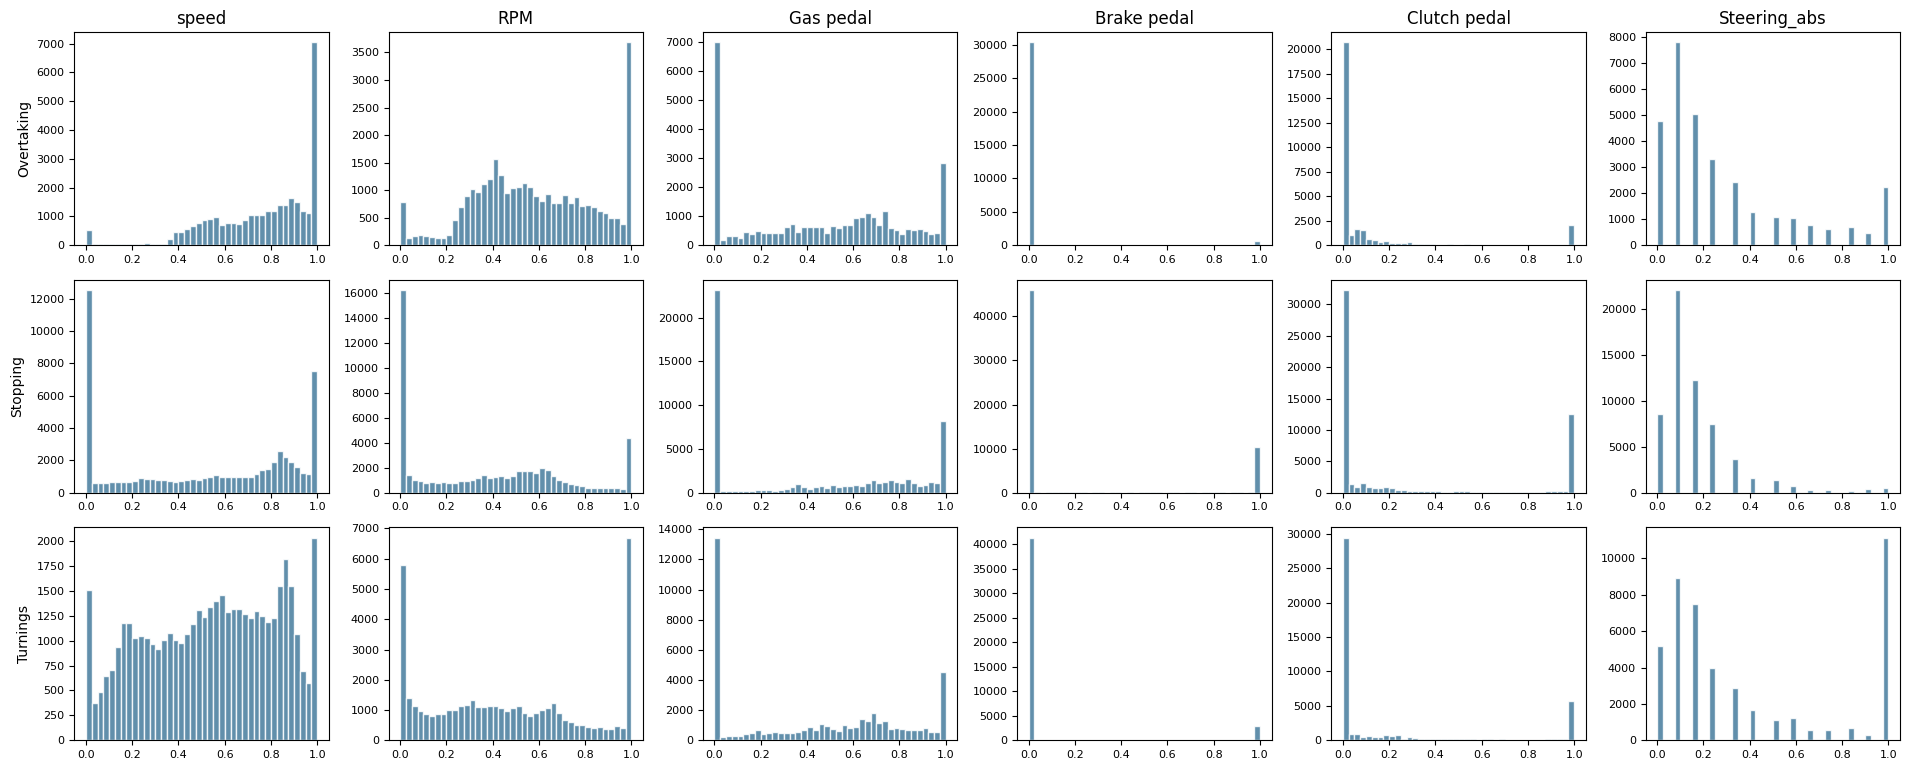

In [19]:
# Histogramas en matriz por maniobra y magnitud (normalizadas)
import matplotlib.pyplot as plt

vars_norm = ["speed", "RPM", "Gas pedal", "Brake pedal", "Clutch pedal", "Steering_abs"]
maneuvers = sorted(df_scaled["maneuver"].dropna().unique())

missing_vars = [v for v in vars_norm if v not in df_scaled.columns]
if missing_vars:
    print("Columnas no encontradas:", missing_vars)

plot_vars = [v for v in vars_norm if v in df_scaled.columns]
nrows = len(maneuvers)
ncols = len(plot_vars)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.2 * ncols, 2.6 * nrows), sharex=False, sharey=False)
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

for i, man in enumerate(maneuvers):
    data_m = df_scaled[df_scaled["maneuver"] == man]
    for j, var in enumerate(plot_vars):
        ax = axes[i][j]
        vals = data_m[var].dropna()
        ax.hist(vals, bins=40, color="#457b9d", alpha=0.85, edgecolor="white")
        if i == 0:
            ax.set_title(var)
        if j == 0:
            ax.set_ylabel(man)
        ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()
plt.show()

In [20]:
# Features por ventana de N muestras, cortando por saltos temporales > 0.65
import numpy as np

window_size = 20
window_overlap = 10
gap_threshold = 0.65

use_recent_weights = True
weight_power = 1.0  # >1 enfatiza aun mas las muestras recientes

if window_overlap < 0 or window_overlap >= window_size:
    raise ValueError("window_overlap debe estar en [0, window_size-1]")
step_size = window_size - window_overlap

df_feat = df_scaled.copy()
df_feat["Elapsed time"] = pd.to_numeric(df_feat["Elapsed time"], errors="coerce")
df_feat = df_feat.sort_values(["driver", "maneuver", "Elapsed time"]).reset_index(drop=True)

def _make_weights(n, power=1.0):
    w = np.linspace(1.0, float(n), n) ** power
    return w / w.sum()

def _weighted_mean(vals, weights):
    vals = np.asarray(vals, dtype=float)
    weights = np.asarray(weights, dtype=float)
    mask = ~np.isnan(vals)
    if mask.sum() == 0:
        return np.nan
    return float(np.average(vals[mask], weights=weights[mask]))

def _slope_norm(y, t, weights=None):
    y = np.asarray(y, dtype=float)
    t = np.asarray(t, dtype=float)
    mask = ~np.isnan(y) & ~np.isnan(t)
    if mask.sum() < 2:
        return np.nan
    y = y[mask]
    t = t[mask]
    w = weights[mask] if weights is not None else None
    t_span = t[-1] - t[0]
    if t_span == 0:
        return 0.0
    if w is not None:
        m = np.polyfit(t, y, 1, w=w)[0]
    else:
        m = np.polyfit(t, y, 1)[0]
    # Normaliza por la duracion para aproximar delta en ventana
    return m * t_span

def _window_features(group):
    group = group.sort_values("Elapsed time").reset_index(drop=True)
    dt = group["Elapsed time"].diff()
    group["_seg"] = (dt > gap_threshold).cumsum()

    rows = []
    for seg_id, seg in group.groupby("_seg", sort=False):
        n = len(seg)
        for start in range(0, n - window_size + 1, step_size):
            w = seg.iloc[start:start + window_size]
            if len(w) < window_size:
                continue
            t = w["Elapsed time"].to_numpy()
            weights = _make_weights(len(w), power=weight_power) if use_recent_weights else None

            speed = w["speed"].astype(float).to_numpy() if "speed" in w.columns else np.full(window_size, np.nan)
            rpm = w["RPM"].astype(float).to_numpy() if "RPM" in w.columns else np.full(window_size, np.nan)
            brake = w["Brake pedal"].astype(float).to_numpy() if "Brake pedal" in w.columns else np.full(window_size, np.nan)
            gas = w["Gas pedal"].astype(float).to_numpy() if "Gas pedal" in w.columns else np.full(window_size, np.nan)

            if "Steering_abs" in w.columns:
                steer_abs = w["Steering_abs"].astype(float).to_numpy()
            else:
                steer_abs = w["Steering wheel angle"].abs().astype(float).to_numpy()

            gear = pd.to_numeric(w["Gear"], errors="coerce") if "Gear" in w.columns else pd.Series([np.nan] * len(w))
            gear_vals = gear.to_numpy()

            # Cambio de marcha solo si hay al menos un valor no-cero y hay cambios entre muestras
            gear_valid = gear_vals[~np.isnan(gear_vals)]
            has_nonzero = np.any(gear_valid != 0) if len(gear_valid) else False
            gear_diff = np.diff(gear_vals)
            gear_change = int(has_nonzero and np.any(~np.isnan(gear_diff) & (gear_diff != 0)))

            if weights is not None:
                speed_level = _weighted_mean(speed, weights)
                rpm_level = _weighted_mean(rpm, weights)
                brake_use = _weighted_mean(brake, weights)
                gas_use = _weighted_mean(gas, weights)
                speed_trend = _slope_norm(speed, t, weights=weights)
                rpm_trend = _slope_norm(rpm, t, weights=weights)
                if len(steer_abs) > 1:
                    steer_activity = _weighted_mean(np.abs(np.diff(steer_abs)), weights[1:])
                else:
                    steer_activity = np.nan
            else:
                speed_level = np.nanmean(speed)
                rpm_level = np.nanmean(rpm)
                brake_use = np.nanmean(brake)
                gas_use = np.nanmean(gas)
                speed_trend = _slope_norm(speed, t)
                rpm_trend = _slope_norm(rpm, t)
                steer_activity = np.nanmean(np.abs(np.diff(steer_abs))) if len(steer_abs) > 1 else np.nan

            flag_mean = np.nan
            if "Maneuver marker flag" in w.columns:
                flag_vals = pd.to_numeric(w["Maneuver marker flag"], errors="coerce").dropna()
                if len(flag_vals):
                    flag_mean = float(flag_vals.mean())

            rows.append({
                "driver": w["driver"].iloc[0],
                "maneuver": w["maneuver"].iloc[0],
                "window_start": t[0],
                "window_end": t[-1],
                "SpeedLevel": speed_level,
                "SpeedTrend": speed_trend,
                "BrakeUse": brake_use,
                "GasUse": gas_use,
                "SteerIntensity": np.nanmax(steer_abs),
                "SteerActivity": steer_activity,
                "GearChange": gear_change,
                "RPMTrend": rpm_trend,
                "RPMLevel": rpm_level,
                "Maneuver marker flag": flag_mean
            })

    return pd.DataFrame(rows)

df_windows = (
    df_feat.groupby(["driver", "maneuver"], group_keys=False)
    .apply(_window_features)
    .reset_index(drop=True)
  )

df_windows.head()

,driver,maneuver,window_start,window_end,SpeedLevel,SpeedTrend,BrakeUse,GasUse,SteerIntensity,SteerActivity,GearChange,RPMTrend,RPMLevel,Maneuver marker flag
0,Driver1,Overtaking,0.111,1.086,0.0,0.0,0.0,0.0,0.5,0.0,0,0.0,0.0,0.0
1,Driver1,Overtaking,0.626,1.600,0.0,0.0,0.0,0.0,0.5,0.0,0,0.0,0.0,0.0
2,Driver1,Overtaking,1.137,2.112,0.0,0.0,0.0,0.0,0.5,0.0,0,0.0,0.0,0.0
3,Driver1,Overtaking,1.652,2.623,0.0,0.0,0.0,0.0,0.5,0.0,0,0.0,0.0,0.0
4,Driver1,Overtaking,2.163,3.141,0.0,0.0,0.0,0.0,0.5,0.0,1,0.0,0.0,0.0


In [22]:
# Filtramos: nos quedamos solo con las filas donde el flag es distinto de 0
df_windows_filtered = df_windows[df_windows["Maneuver marker flag"] != 0].copy()

# Guardamos el resultado filtrado
df_windows_filtered.to_csv("data_processed.csv", index=False)

print(f"Filas originales: {len(df_windows)}")
print(f"Filas después de filtrar: {len(df_windows_filtered)}")

Filas originales: 13622
Filas después de filtrar: 5398
